# GOAL: ID LIST SPLIT 한 후에 FIX하여 학습진행 및 모델 고도화

In [1]:
import pandas as pd
import numpy as np
#import tensorflow as tf 
import os
import sys
from datetime import datetime, timedelta
from tqdm.autonotebook import tqdm
import csv
import re
from tensorflow.keras.optimizers import Adam
from xgboost import XGBClassifier
import scikitplot as skplt
import gzip
import shutil
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import (
    Activation,
    AveragePooling2D,
    Dense,
    Dropout,
    Input,
    LSTM,
    GRU,
    Embedding,
    Bidirectional
)
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, classification_report
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import sys


In [2]:
path = '/data2/je_hong/kaist/kaist/physionet.org/files/mimiciv/2.0/icu/'

In [3]:
new_path = '/data2/je_hong/kaist/kaist/physionet.org/files/mimiciv/2.0/mimic_rev/'

In [4]:
hos_path = '/data2/je_hong/kaist/kaist/physionet.org/files/mimiciv/2.0/hosp/'

In [43]:
import pickle
with gzip.open(new_path+'new_dict/death_dataset_20221112.pickle','rb') as f:  
    death_dataset = pickle.load(f)

In [44]:
hadm_ids = death_dataset['HADM_IDS']

In [33]:
peni_id = pd.read_csv(new_path+'new_csv/id_peni.csv')
macro_id = pd.read_csv(new_path+'new_csv/id_macro.csv')
glyco_id = pd.read_csv(new_path+'new_csv/id_glyco.csv')
fluoro_id = pd.read_csv(new_path+'new_csv/id_fluoro.csv')
cepha_id = pd.read_csv(new_path+'new_csv/id_cepha.csv')

In [47]:
## Define some util functions
NOT_CONVERTED = 'NOT_CONVERTED'
## 문자로 기록된 날짜 값들을 파이썬의 datetime 데이터로 바꿔주는 함수 작성
def str2datetime(s):
    def _convert(_s, _dformat):
        try:
            converted_dt = datetime.strptime(_s, _dformat)
        except Exception:
            return NOT_CONVERTED

        return converted_dt

    if isinstance(s, datetime):
        return s

    dformats = [
        '%Y-%m-%d %p %I:%M:%S',
        '%Y-%m-%d %H:%M:%S.%f',
        '%Y-%m-%d %H:%M:%S',
        '%Y-%m-%d %H:%M',
        '%y-%m-%d %H:%M',
        '%Y-%m-%d',
        '%Y%m%d',
        '%Y-%m-%d +%H:%M',
        '%Y%m%d %H%M',
        '%Y%m%d%H%M%S',
        ]

    s = s.split('.')[0]
    s = s.replace('오전', 'am').replace('오후', 'pm')
    for dformat in dformats:
        dt = _convert(s, dformat)
        if dt != NOT_CONVERTED:
            return dt

    return NOT_CONVERTED

In [48]:
# 사망 레이블 하기
death_labels = dict()
admissions = csv.DictReader(open("/data2/je_hong/kaist/kaist/physionet.org/files/mimiciv/2.0/mimiciv_der/sepsis3_admissions.csv", 'r', encoding='utf-8'))
for row in tqdm(admissions, desc='Get Death Label'):
    hadm_id = row['hadm_id']
    death_yn = int(row['hospital_expire_flag'])
    if death_yn:
        event_time = str2datetime(row['deathtime'])
    else:
        event_time = str2datetime(row['dischtime'])
        death_labels[hadm_id] = dict({'DEATH': death_yn, 'EVENT_TIME': event_time})

Get Death Label: 0it [00:00, ?it/s]

In [49]:
# 재실 기간 레이블 하기
los_labels = dict()
admissions = csv.DictReader(open('/data2/je_hong/kaist/kaist/physionet.org/files/mimiciv/2.0/mimiciv_der/sepsis3_admissions.csv', 'r', encoding='utf-8'))
for row in tqdm(admissions, desc='Get loss Label'):
    hadm_id = row['hadm_id']
    admin_time = str2datetime(row['admittime'])
    disc_time = str2datetime(row['dischtime'])
    los = (disc_time - admin_time).total_seconds() / (60*60)
    los_labels[hadm_id] = int(los)

Get loss Label: 0it [00:00, ?it/s]

In [50]:
## 환자의 입실 퇴실 시간 정보 가져오기
Extracted_HADMIDS = hadm_ids
admin_disc_time = dict()

admissions = csv.DictReader(open('/data2/je_hong/kaist/kaist/physionet.org/files/mimiciv/2.0/mimiciv_der/sepsis3_admissions.csv', 'r', encoding='utf-8'))
for row in admissions:
    hadm_id = row['hadm_id']
    admin_time = str2datetime(row['admittime'])
    disc_time = str2datetime(row['dischtime'])

    if (admin_time != NOT_CONVERTED) and (disc_time != NOT_CONVERTED):
        admin_disc_time[hadm_id] = dict({'ADMIN': admin_time, 'DISC': disc_time})

In [51]:
feature_keys = ['FiO2', 'HR', 'PaO2', 'SBP', 'Temperature','Creatinine','Glucose', 'Hb', 'Lactate', 'Plt','Sodium' ,'WBC','DBP', 'MAP', 'RESP', 'Chloride', 'Hct', 'PCO2', 'Potassium', 'PH', 'Anion Gap', 'Bilirubin']

EXTRACT_FEATURE_CODES_VS = dict({
    '226754': 'FiO2', '223835': 'FiO2', '227010': 'FiO2', '229280': 'FiO2', '229841': 'FiO2',
    '220045': 'HR', '220046': 'HR', '226764': 'HR', '227018': 'HR',
    '220224': 'PaO2', '227039': 'PaO2', '227516': 'PaO2',
    '220050': 'SBP' ,'220179': 'SBP', '224167': 'SBP', '227243': 'SBP', '228152': 'SBP',
    '223762': 'Temperature', '226329': 'Temperature', '227632': 'Temperature', '227634': 'Temperature',
    '50825': 'Temperature',
    ####### 새로운 features ##########
   '223761': 'TEMP_F',
   '225310': 'DBP', '220051': 'DBP', '220180': 'DBP',
   '225312': 'MAP', '220052': 'MAP', '220181': 'MAP',
   '220210': 'RESP', '224690': 'RESP'
    })
EXTRACT_FEATURE_CODES_LAB = dict({
    '220615': 'Creatinine', '229761': 'Creatinine',
    '52024': 'Creatinine', '50912': 'Creatinine', '52546': 'Creatinine', '51977': 'Creatinine',  '51081': 'Creatinine',
    '220621': 'Glucose', '225664': 'Glucose', '226537': 'Glucose',
    '50809': 'Glucose', '52027': 'Glucose', '50931': 'Glucose', '52569': 'Glucose', '51981': 'Glucose', '51478': 'Glucose',
    '220228': 'Hb',
    '50811': 'Hb', '50855': 'Hb', '51640': 'Hb', '51645': 'Hb', '51222': 'Hb', '52157': 'Hb',
    '225668': 'Lactate',
    '50813': 'Lactate', '52442': 'Lactate',
    '227457': 'Plt',
    '51704': 'Plt', '51265': 'Plt',
    '220645': 'Sodium', '226534': 'Sodium',
    '50824': 'Sodium', '52455': 'Sodium', '50983': 'Sodium', '52623': 'Sodium',
    '220546': 'WBC',
    '51755': 'WBC', '51756': 'WBC', '51301': 'WBC',
    ######### 새로운 features ############
    '50902': 'Chloride', '50806': 'Chloride',
    '50810': 'Hct', '51221': 'Hct',
    '50810': 'PCO2',
    '50822': 'Potassium', '50971': 'Potassium', '845825': 'Potassium',
    '50820': 'PH',
    '50868': 'Anion Gap', '769895': 'Anion Gap', '52456': 'Anion Gap', 
    '50885': 'Bilirubin'})

EXTRACT_FEATURE_CODES_NORMAL = dict({ #outlier 범위 - medical knowledge에 기반하여 계산
        'FiO2': [10, 100],
        'HR': [30, 200],
        'PaO2': [50, 200],
        'SBP': [40, 250],
        'Temperature': [30, 45],
        'Creatinine': [0.2, 100],
        'Glucose': [30, 1000],
        'Hb': [5, 20],
        'Lactate': [0.5, 2.5],
        'Plt': [10, 500],
        'Sodium': [90, 170],
        'WBC': [1, 30],
        'DBP':[30, 200],
        'MAP':[33, 216],
        'RESP':[0, 35],
        'Chloride':[70, 130],
        'Hct':[10, 50], 
        'PCO2':[5, 100],
        'Potassium':[1.0, 10.0],
        'PH':[5.5, 8.0],
        'Anion Gap':[5, 50],
        'Bilirubin':[0.1, 10]
})
NORMAL_VALUE = dict({ #missing value 대체값
        'FiO2': 40,
        'HR': 75, #(50+100)/2
        'PaO2': 87.5, #(75+100)/2
        'SBP': 115, #(90+140)/2 = 115
        'Temperature': 36.65, #(36.1+37.2)/2
        'Creatinine': 1.0, #(0.7+1.0)/2
        'Glucose': 100, #(60+140)/2
        'Hb': 15.0, #(13.8+17.2)/2
        'Lactate': 1.35, #(0.5+2.2)/2 = 1.35
        'Plt': 270, #(140+400)/2
        'Sodium': 140, #(135+145)/2
        'WBC': 7.5, #(5+10)/2
        'WBC': 7.5, #(5+10)/2
        'DBP': 90, #(80+100)/2 
        'MAP': 98, # (115 + 2*90) / 
        'RESP': 13, 
        'Chloride': 102, #(96+108) / 2
        'Hct': 34.5, #(34+45)/2
        'PCO2': 40, #(35+45)/2
        'Potassium': 4.5, #(3.5+5.4)/2
        'PH': 7.4, #(7.35 + 7.45) / 2
        'Anion Gap': 14, #8+20/2
        'Bilirubin': 0.8 #0+1.5/2
})

In [52]:
total_death_included_hadm_ids = list(death_labels.keys())
total_los_included_hadm_ids = list(los_labels.keys())

In [53]:
for i in range(len(death_dataset['DATA'])):
    if (death_dataset['DATA'][i].shape[0]) < 13:
        zeros = np.zeros((13, death_dataset['DATA'][i].shape[1]))
        zeros[:death_dataset['DATA'][i].shape[0], :] = death_dataset['DATA'][i]
        death_dataset['DATA'][i] = zeros
    else:
        death_dataset['DATA'][i] = death_dataset['DATA'][i][:13] 

In [54]:
def making_num(id_list):
    X = np.zeros((len(id_list) , 13, 22))
    y = np.zeros((len(id_list), 1))
    j = 0
    for idx, i in (enumerate(tqdm(death_dataset['HADM_IDS']))):
        if int(i) in id_list['hadm_id'].tolist():
            X[j] = death_dataset['DATA'][idx]
    #         print(death_dataset['DATA'][idx].reshape)
            y[j] = death_dataset['LABEL'][idx]
            j += 1
    return X, y

In [91]:
# 25개 따로 빼서 
peni_id.drop(index = [10, 20, 9, 50, 100], inplace=True)
macro_id.drop(index = [10, 20, 9, 50, 100], inplace=True)
glyco_id.drop(index = [10, 20, 9, 50, 100], inplace=True)
fluoro_id.drop(index = [10, 20, 9, 50, 100], inplace=True)
cepha_id.drop(index = [10, 20, 9, 50, 100], inplace=True)

In [37]:
peni_drop_df = peni_id.loc[[10, 20, 9, 50, 100]]
macro_drop_df = macro_id.loc[[10, 20, 9, 50, 100]]
glyco_drop_df = glyco_id.loc[[10, 20, 9, 50, 100]]
fluoro_drop_df = fluoro_id.loc[[10, 20, 9, 50, 100]]
cepha_drop_df = cepha_id.loc[[10, 20, 9, 50, 100]]

In [39]:
drop_df = pd.concat([peni_drop_df, macro_drop_df, glyco_drop_df, fluoro_drop_df, cepha_drop_df], axis=0)

In [55]:
drop_X, drop_y = making_num(drop_df)

  0%|          | 0/32340 [00:00<?, ?it/s]

In [92]:
(peni_X, peni_y) = making_num(peni_id)
(macro_X, macro_y) = making_num(macro_id)
(glyco_X, glyco_y) = making_num(glyco_id)
(fluoro_X, fluoro_y) = making_num(fluoro_id)
(cepha_X, cepha_y) = making_num(cepha_id)

  0%|          | 0/32340 [00:00<?, ?it/s]

  0%|          | 0/32340 [00:00<?, ?it/s]

  0%|          | 0/32340 [00:00<?, ?it/s]

  0%|          | 0/32340 [00:00<?, ?it/s]

  0%|          | 0/32340 [00:00<?, ?it/s]

In [93]:
print(peni_X.shape, peni_y.shape, macro_X.shape,macro_y.shape, glyco_X.shape, glyco_y.shape, fluoro_X.shape, fluoro_y.shape, cepha_X.shape, cepha_y.shape)

(6067, 13, 22) (6067, 1) (1915, 13, 22) (1915, 1) (11761, 13, 22) (11761, 1) (3649, 13, 22) (3649, 1) (10958, 13, 22) (10958, 1)


In [56]:
# peni_Y = to_categorical(peni_y)
# macro_Y = to_categorical(macro_y)
# glyco_Y = to_categorical(glyco_y)
# fluoro_Y = to_categorical(fluoro_y)
# cepha_Y = to_categorical(cepha_y)
drop_Y = to_categorical(drop_y)

In [59]:
drop_X.shape

(25, 13, 22)

In [95]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split
def split_train_test(X, y, id_list):
    idx = list(range(len(X)))
    ids = id_list
    train_idx, valid_idx, y_train, y_valid = train_test_split(idx, y, test_size=0.1, shuffle=True, stratify=y)
    test_idx, valid_idx, y_test, y_valid = train_test_split(valid_idx, y_valid, test_size=0.5, shuffle=True, stratify=y_valid)
    train_id = [ids[i] for i in train_idx]
    test_id = [ids[i] for i in test_idx]
    valid_id = [ids[i] for i in valid_idx]
    id_dict = {'train_idx': train_idx, 'train_id':train_id, 'valid_idx':valid_idx, 'valid_id':valid_id, 'test_idx': test_idx, 'test_id':test_id}
    train_x  = [X[i] for i in id_dict['train_idx']]
    test_x  = [X[i] for i in id_dict['test_idx']]
    valid_x  = [X[i] for i in id_dict['valid_idx']]
    train_y  = [y[i] for i in id_dict['train_idx']]
    test_y  = [y[i] for i in id_dict['test_idx']]
    valid_y  = [y[i] for i in id_dict['valid_idx']]
    
#     xgb = XGBClassifier().fit(x_train, y_train)
#     predictions = xgb.predict_proba(x_valid)
    return train_x, valid_x, test_x, train_y, valid_y, test_y, id_dict


In [96]:
x_peni_train, x_peni_valid, x_peni_test, y_peni_train, y_peni_valid, y_peni_test, peni_id_dict  = split_train_test(peni_X, peni_Y, peni_id['hadm_id'].tolist())
x_macro_train, x_macro_valid, x_macro_test, y_macro_train, y_macro_valid, y_macro_test, macro_id_dict = split_train_test(macro_X, macro_Y, macro_id['hadm_id'].tolist())
x_glyco_train, y_glyco_train, x_glyco_valid, y_glyco_valid,  x_glyco_test, y_glyco_test, glyco_id_dict = split_train_test(glyco_X, glyco_Y, glyco_id['hadm_id'].tolist())
x_fluoro_train, x_fluoro_valid, x_fluoro_test, y_fluoro_train, y_fluoro_valid,y_fluoro_test, fluoro_id_dict = split_train_test(fluoro_X, fluoro_Y, fluoro_id['hadm_id'].tolist())
x_cepha_train, x_cepha_valid, x_cepha_test, y_cepha_train, y_cepha_valid, y_cepha_test, cepha_id_dict = split_train_test(cepha_X, cepha_Y, cepha_id['hadm_id'].tolist())


In [97]:
def save_dict_numpy(id_dict, train_x, valid_x, test_x, train_y, valid_y, test_y, type_):
    import pickle
    with open('/data2/je_hong/kaist/kaist/physionet.org/files/mimiciv/2.0/mimic_rev/new_dict/{}/id_list.pkl'.format(type_),'wb') as f:
         pickle.dump(id_dict, f)
    np.savez_compressed('/data2/je_hong/kaist/kaist/physionet.org/files/mimiciv/2.0/mimic_rev/numpy/{}/train_test_valid.npz'.format(type_), train_x = train_x, valid_x=valid_x, test_x=test_x, train_y=train_y, test_y=test_y, valid_y=valid_y)
    

In [98]:
save_dict_numpy(peni_id_dict, x_peni_train, x_peni_valid, x_peni_test, y_peni_train, y_peni_valid, y_peni_test, 'peni')
save_dict_numpy(macro_id_dict, x_macro_train, x_macro_valid, x_macro_test, y_macro_train, y_macro_valid, y_macro_test, 'macro')
save_dict_numpy(glyco_id_dict, x_glyco_train, y_glyco_train, x_glyco_valid, y_glyco_valid,  x_glyco_test, y_glyco_test, 'glyco')
save_dict_numpy(fluoro_id_dict, x_fluoro_train, x_fluoro_valid, x_fluoro_test, y_fluoro_train, y_fluoro_valid,y_fluoro_test, 'fluoro')
save_dict_numpy(cepha_id_dict,x_cepha_train, x_cepha_valid, x_cepha_test, y_cepha_train, y_cepha_valid, y_cepha_test, 'cepha')

In [66]:
# train_test_peni = np.load('/data2/je_hong/kaist/kaist/physionet.org/files/mimiciv/2.0/mimic_rev/numpy/peni/train_test_valid.npz')
# train_test_macro = np.load('/data2/je_hong/kaist/kaist/physionet.org/files/mimiciv/2.0/mimic_rev/numpy/macro/train_test_valid.npz')
# train_test_glyco = np.load('/data2/je_hong/kaist/kaist/physionet.org/files/mimiciv/2.0/mimic_rev/numpy/glyco/train_test_valid.npz')
# train_test_fluoro = np.load('/data2/je_hong/kaist/kaist/physionet.org/files/mimiciv/2.0/mimic_rev/numpy/fluoro/train_test_valid.npz')
# train_test_cepha = np.load('/data2/je_hong/kaist/kaist/physionet.org/files/mimiciv/2.0/mimic_rev/numpy/cepha/train_test_valid.npz')

In [5]:
def loaded_data(path):
    train_test_split = np.load(path)
    train_x = train_test_split['train_x']
    test_x = train_test_split['test_x']
    valid_x = train_test_split['valid_x']
    train_y = train_test_split['train_y']
    test_y = train_test_split['test_y']
    valid_y = train_test_split['valid_y']
    print('train_x shape: {}'.format(train_x.shape), 'valid_x shape: {}'.format(valid_x.shape),
          "test_x shape: {}".format(test_x.shape), "train_y shape: {}".format(train_y.shape),
          "valid_y shape: {}".format(valid_y.shape),
          "test_y shape: {}".format(test_y.shape))
    print("------------------------------------------------------------------------------")
    return train_x, valid_x, test_x, train_y, valid_y, test_y

In [6]:
x_peni_train, x_peni_valid, x_peni_test, y_peni_train, y_peni_valid, y_peni_test = loaded_data('/data2/je_hong/kaist/kaist/physionet.org/files/mimiciv/2.0/mimic_rev/numpy/peni/train_test_valid.npz')
x_macro_train, x_macro_valid, x_macro_test, y_macro_train, y_macro_valid, y_macro_test = loaded_data('/data2/je_hong/kaist/kaist/physionet.org/files/mimiciv/2.0/mimic_rev/numpy/macro/train_test_valid.npz')
x_glyco_train, x_glyco_valid, x_glyco_test, y_glyco_train, y_glyco_valid,  y_glyco_test = loaded_data('/data2/je_hong/kaist/kaist/physionet.org/files/mimiciv/2.0/mimic_rev/numpy/glyco/train_test_valid.npz')
x_fluoro_train, x_fluoro_valid, x_fluoro_test, y_fluoro_train, y_fluoro_valid, y_fluoro_test = loaded_data('/data2/je_hong/kaist/kaist/physionet.org/files/mimiciv/2.0/mimic_rev/numpy/fluoro/train_test_valid.npz')
x_cepha_train, x_cepha_valid, x_cepha_test, y_cepha_train, y_cepha_valid, y_cepha_test = loaded_data('/data2/je_hong/kaist/kaist/physionet.org/files/mimiciv/2.0/mimic_rev/numpy/cepha/train_test_valid.npz')

train_x shape: (5460, 13, 22) valid_x shape: (304, 13, 22) test_x shape: (303, 13, 22) train_y shape: (5460, 2) valid_y shape: (304, 2) test_y shape: (303, 2)
------------------------------------------------------------------------------
train_x shape: (1723, 13, 22) valid_x shape: (96, 13, 22) test_x shape: (96, 13, 22) train_y shape: (1723, 2) valid_y shape: (96, 2) test_y shape: (96, 2)
------------------------------------------------------------------------------
train_x shape: (10584, 13, 22) valid_x shape: (589, 13, 22) test_x shape: (588, 13, 22) train_y shape: (10584, 2) valid_y shape: (589, 2) test_y shape: (588, 2)
------------------------------------------------------------------------------
train_x shape: (3284, 13, 22) valid_x shape: (183, 13, 22) test_x shape: (182, 13, 22) train_y shape: (3284, 2) valid_y shape: (183, 2) test_y shape: (182, 2)
------------------------------------------------------------------------------
train_x shape: (9862, 13, 22) valid_x shape: (548,

In [7]:
def model_gru(model_input):
    model_gru = GRU(50, activation='relu')(model_input)
    model_gru = Dense(10, activation='relu')(model_gru)
    output = Dense(2, activation='softmax')(model_gru)
    model = Model(model_input, output)
    print(model.summary())
    return model

In [28]:
model_input = Input(shape=(x_cepha_train.shape[1], x_cepha_train.shape[2]))
model = model_gru(model_input)
model.compile(Adam(lr=1e-3), loss='categorical_crossentropy', metrics='acc')

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 13, 22)]          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 50)                11100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 22        
Total params: 11,632
Trainable params: 11,632
Non-trainable params: 0
_________________________________________________________________
None


/home/je_hong/.local/lib/python3.6/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [9]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=1, factor=0.6),
             EarlyStopping(monitor='val_loss', patience=20),
             ModelCheckpoint(filepath=new_path+'model/{} model'.format("cepha"), monitor='val_loss', save_best_only=True)]

In [11]:
history = model.fit(x_cepha_train, y_cepha_train, 
          epochs = 40, 
          batch_size = 16, 
          validation_data=(x_cepha_valid,  y_cepha_valid), 
          verbose=1,callbacks=callbacks)

Epoch 1/40
617/617 [==============================] - 7s 11ms/step - loss: 0.3582 - acc: 0.8664 - val_loss: 0.3694 - val_acc: 0.8686
INFO:tensorflow:Assets written to: /data2/je_hong/kaist/kaist/physionet.org/files/mimiciv/2.0/mimic_rev/model/cepha model/assets
Epoch 2/40
617/617 [==============================] - 7s 11ms/step - loss: 0.3563 - acc: 0.8658 - val_loss: 0.3715 - val_acc: 0.8613
Epoch 3/40
617/617 [==============================] - 6s 10ms/step - loss: 0.3737 - acc: 0.8653 - val_loss: 0.3763 - val_acc: 0.8668
Epoch 4/40
617/617 [==============================] - 7s 11ms/step - loss: 0.3851 - acc: 0.8663 - val_loss: 0.3696 - val_acc: 0.8613
Epoch 5/40
617/617 [==============================] - 7s 11ms/step - loss: 0.3488 - acc: 0.8669 - val_loss: 0.3662 - val_acc: 0.8650
INFO:tensorflow:Assets written to: /data2/je_hong/kaist/kaist/physionet.org/files/mimiciv/2.0/mimic_rev/model/cepha model/assets
Epoch 6/40
617/617 [==============================] - 7s 11ms/step - loss: 0.

(548, 2) (548, 2)
              precision    recall  f1-score   support

      normal     0.8729    0.9808    0.9237       469
    diabetes     0.5714    0.1519    0.2400        79

    accuracy                         0.8613       548
   macro avg     0.7221    0.5664    0.5818       548
weighted avg     0.8294    0.8613    0.8251       548

0.7445952875765836
0.7445952875765836
(548,)


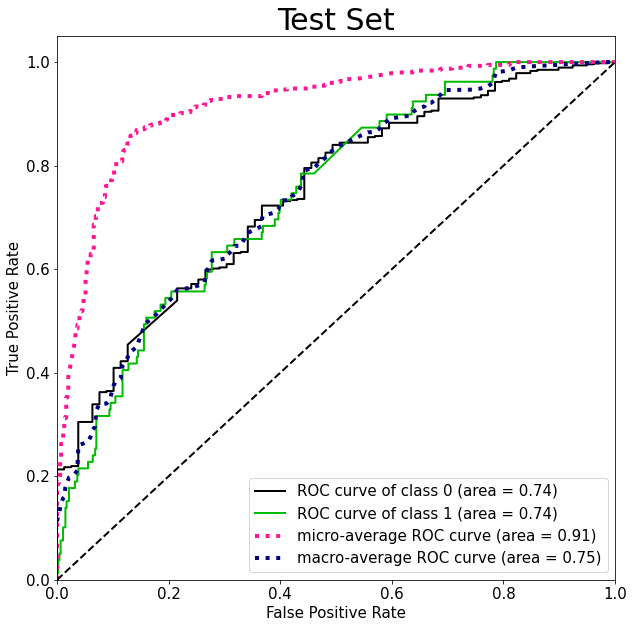

In [60]:
# model.save('/data2/je_hong/kaist/kaist/physionet.org/files/mimiciv/2.0/mimic_rev/model/cepha model/cepha_best_model.h5')
model = load_model('/data2/je_hong/kaist/kaist/physionet.org/files/mimiciv/2.0/mimic_rev/model/cepha model/cepha_best_model.h5')
predictions = model.predict(x_cepha_test)
y_true = np.argmax(y_cepha_test, axis=1)
y_pred = np.argmax(predictions, axis=1)
print(predictions.shape, y_cepha_test.shape)
fpr = dict()
tpr = dict()
roc_auc = dict()
target_names = ['normal', 'diabetes']

print(classification_report(y_true, y_pred, target_names=target_names, digits=4))
print(1 - roc_auc_score(y_true, predictions[:, 0]))
print(roc_auc_score(y_true, predictions[:, 1]))
skplt.metrics.plot_roc(
    y_true, predictions, title="Test Set", figsize=(10, 10), text_fontsize=15, title_fontsize=30,
)
print(y_true.shape)

(96, 2) (96, 2)
              precision    recall  f1-score   support

      normal     0.8889    0.9877    0.9357        81
    diabetes     0.8333    0.3333    0.4762        15

    accuracy                         0.8854        96
   macro avg     0.8611    0.6605    0.7059        96
weighted avg     0.8802    0.8854    0.8639        96

0.7283950617283951
0.7283950617283951
(96,)


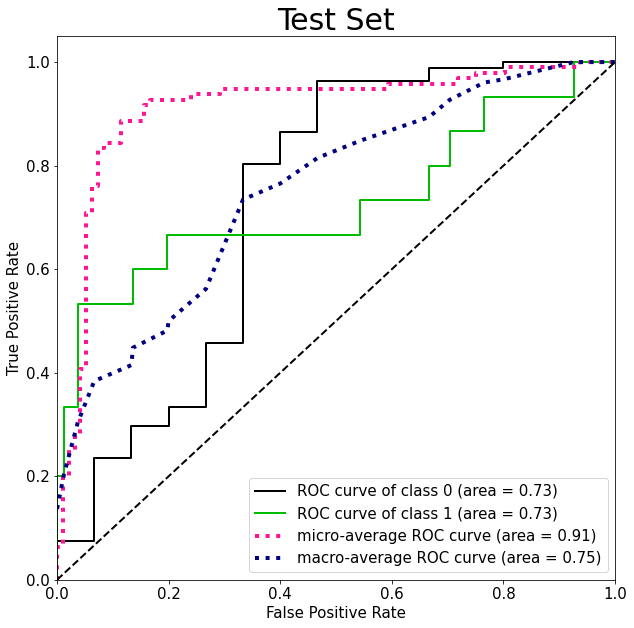

In [75]:
# model.save('/data2/je_hong/kaist/kaist/physionet.org/files/mimiciv/2.0/mimic_rev/model/cepha model/cepha_best_model.h5')
model = load_model('/data2/je_hong/kaist/kaist/physionet.org/files/mimiciv/2.0/mimic_rev/model/cepha model/cepha_best_model.h5')
predictions = model.predict(x_macro_test)
y_true = np.argmax(y_macro_test, axis=1)
y_pred = np.argmax(predictions, axis=1)
print(predictions.shape, y_macro_test.shape)
fpr = dict()
tpr = dict()
roc_auc = dict()
target_names = ['normal', 'diabetes']

print(classification_report(y_true, y_pred, target_names=target_names, digits=4))
print(1 - roc_auc_score(y_true, predictions[:, 0]))
print(roc_auc_score(y_true, predictions[:, 1]))
skplt.metrics.plot_roc(
    y_true, predictions, title="Test Set", figsize=(10, 10), text_fontsize=15, title_fontsize=30,
)
print(y_true.shape)

## peni

In [29]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=1, factor=0.6),
             EarlyStopping(monitor='val_loss', patience=20),
             ModelCheckpoint(filepath=new_path+'model/{} model'.format("peni"), monitor='val_loss', save_best_only=True)]

In [30]:
history = model.fit(x_peni_train, y_peni_train, 
          epochs = 40, 
          batch_size = 16, 
          validation_data=(x_peni_valid,  y_peni_valid), 
          verbose=1,callbacks=callbacks)

Epoch 1/40
342/342 [==============================] - 8s 12ms/step - loss: 0.4876 - acc: 0.8077 - val_loss: 0.4943 - val_acc: 0.8059
INFO:tensorflow:Assets written to: /data2/je_hong/kaist/kaist/physionet.org/files/mimiciv/2.0/mimic_rev/model/peni model/assets
Epoch 2/40
342/342 [==============================] - 4s 11ms/step - loss: 0.4615 - acc: 0.8137 - val_loss: 0.4691 - val_acc: 0.8026
INFO:tensorflow:Assets written to: /data2/je_hong/kaist/kaist/physionet.org/files/mimiciv/2.0/mimic_rev/model/peni model/assets
Epoch 3/40
342/342 [==============================] - 4s 10ms/step - loss: 0.4537 - acc: 0.8185 - val_loss: 0.6244 - val_acc: 0.8125
Epoch 4/40
342/342 [==============================] - 4s 11ms/step - loss: 0.4467 - acc: 0.8187 - val_loss: 0.7198 - val_acc: 0.8026
Epoch 5/40
342/342 [==============================] - 4s 11ms/step - loss: 0.4490 - acc: 0.8185 - val_loss: 0.7144 - val_acc: 0.8092
Epoch 6/40
342/342 [==============================] - 4s 11ms/step - loss: 0.44

(303, 2) (303, 2)
              precision    recall  f1-score   support

      normal     0.8431    0.9545    0.8953       242
    diabetes     0.6207    0.2951    0.4000        61

    accuracy                         0.8218       303
   macro avg     0.7319    0.6248    0.6477       303
weighted avg     0.7983    0.8218    0.7956       303

0.7606015445061645
0.7606015445061645
(303,)


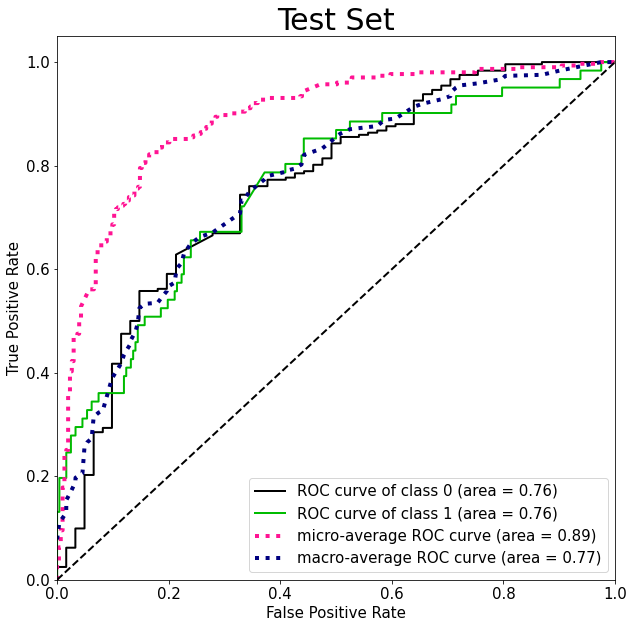

In [72]:
# model.save('/data2/je_hong/kaist/kaist/physionet.org/files/mimiciv/2.0/mimic_rev/model/peni model/peni_best_model.h5')
model = load_model('/data2/je_hong/kaist/kaist/physionet.org/files/mimiciv/2.0/mimic_rev/model/peni model/peni_best_model.h5')
predictions = model.predict(x_peni_test)
y_true = np.argmax(y_peni_test, axis=1)
y_pred = np.argmax(predictions, axis=1)
print(predictions.shape, y_peni_test.shape)
fpr = dict()
tpr = dict()
roc_auc = dict()
target_names = ['normal', 'diabetes']

print(classification_report(y_true, y_pred, target_names=target_names, digits=4))
print(1 - roc_auc_score(y_true, predictions[:, 0]))
print(roc_auc_score(y_true, predictions[:, 1]))
skplt.metrics.plot_roc(
    y_true, predictions, title="Test Set", figsize=(10, 10), text_fontsize=15, title_fontsize=30,
)
print(y_true.shape)


## macro

In [16]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=1, factor=0.6),
             EarlyStopping(monitor='val_loss', patience=20),
             ModelCheckpoint(filepath=new_path+'model/{} model'.format("macro"), monitor='val_loss', save_best_only=True)]

In [17]:
history = model.fit(x_macro_train, y_macro_train, 
          epochs = 40, 
          batch_size = 16, 
          validation_data=(x_macro_valid,  y_macro_valid), 
          verbose=1,callbacks=callbacks)

Epoch 1/40
108/108 [==============================] - 4s 18ms/step - loss: 0.4083 - auc: 0.8893 - val_loss: 0.4151 - val_auc: 0.8750
INFO:tensorflow:Assets written to: /data2/je_hong/kaist/kaist/physionet.org/files/mimiciv/2.0/mimic_rev/model/macro model/assets
Epoch 2/40
108/108 [==============================] - 1s 12ms/step - loss: 0.4082 - auc: 0.8894 - val_loss: 0.4150 - val_auc: 0.8750
INFO:tensorflow:Assets written to: /data2/je_hong/kaist/kaist/physionet.org/files/mimiciv/2.0/mimic_rev/model/macro model/assets
Epoch 3/40
108/108 [==============================] - 1s 12ms/step - loss: 0.4082 - auc: 0.8894 - val_loss: 0.4150 - val_auc: 0.8750
INFO:tensorflow:Assets written to: /data2/je_hong/kaist/kaist/physionet.org/files/mimiciv/2.0/mimic_rev/model/macro model/assets
Epoch 4/40
108/108 [==============================] - 1s 11ms/step - loss: 0.4081 - auc: 0.8894 - val_loss: 0.4149 - val_auc: 0.8757
INFO:tensorflow:Assets written to: /data2/je_hong/kaist/kaist/physionet.org/files

(96, 2) (96, 2)
              precision    recall  f1-score   support

      normal     0.8876    0.9753    0.9294        81
    diabetes     0.7143    0.3333    0.4545        15

    accuracy                         0.8750        96
   macro avg     0.8010    0.6543    0.6920        96
weighted avg     0.8606    0.8750    0.8552        96

0.7547325102880659
0.7547325102880658
(96,)


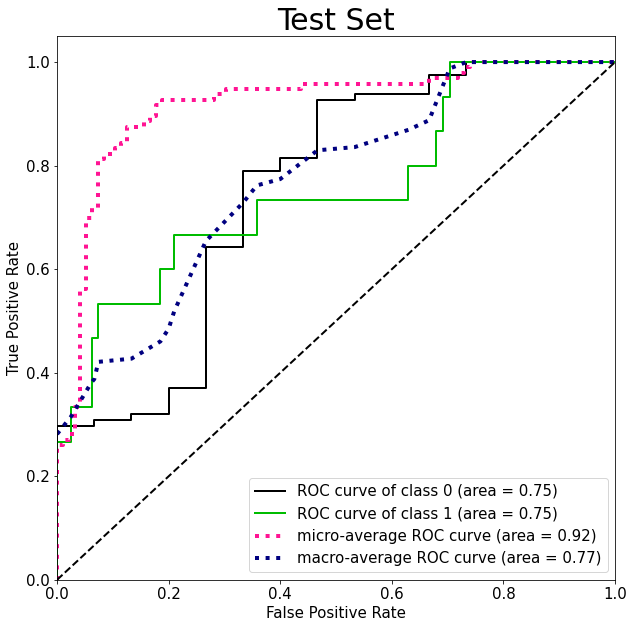

In [18]:
model.save('/data2/je_hong/kaist/kaist/physionet.org/files/mimiciv/2.0/mimic_rev/model/macro model/macro_best_model.h5')
model = load_model('/data2/je_hong/kaist/kaist/physionet.org/files/mimiciv/2.0/mimic_rev/model/macro model/macro_best_model.h5')
predictions = model.predict(x_macro_test)
y_true = np.argmax(y_macro_test, axis=1)
y_pred = np.argmax(predictions, axis=1)
print(predictions.shape, y_macro_test.shape)
fpr = dict()
tpr = dict()
roc_auc = dict()
target_names = ['normal', 'diabetes']

print(classification_report(y_true, y_pred, target_names=target_names, digits=4))
print(1 - roc_auc_score(y_true, predictions[:, 0]))
print(roc_auc_score(y_true, predictions[:, 1]))
skplt.metrics.plot_roc(
    y_true, predictions, title="Test Set", figsize=(10, 10), text_fontsize=15, title_fontsize=30,
)
print(y_true.shape)

## glyco

In [19]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=1, factor=0.6),
             EarlyStopping(monitor='val_loss', patience=20),
             ModelCheckpoint(filepath=new_path+'model/{} model'.format("glyco"), monitor='val_loss', save_best_only=True)]

In [20]:
history = model.fit(x_glyco_train, y_glyco_train, 
          epochs = 40, 
          batch_size = 16, 
          validation_data=(x_glyco_valid, y_glyco_valid), 
          verbose=1, callbacks=callbacks)

Epoch 1/40
662/662 [==============================] - 10s 12ms/step - loss: 0.4564 - auc: 0.8642 - val_loss: 0.4352 - val_auc: 0.8795
INFO:tensorflow:Assets written to: /data2/je_hong/kaist/kaist/physionet.org/files/mimiciv/2.0/mimic_rev/model/glyco model/assets
Epoch 2/40
662/662 [==============================] - 7s 11ms/step - loss: 0.4561 - auc: 0.8642 - val_loss: 0.4350 - val_auc: 0.8795
INFO:tensorflow:Assets written to: /data2/je_hong/kaist/kaist/physionet.org/files/mimiciv/2.0/mimic_rev/model/glyco model/assets
Epoch 3/40
662/662 [==============================] - 7s 11ms/step - loss: 0.4558 - auc: 0.8646 - val_loss: 0.4349 - val_auc: 0.8795
INFO:tensorflow:Assets written to: /data2/je_hong/kaist/kaist/physionet.org/files/mimiciv/2.0/mimic_rev/model/glyco model/assets
Epoch 4/40
662/662 [==============================] - 7s 11ms/step - loss: 0.4556 - auc: 0.8645 - val_loss: 0.4347 - val_auc: 0.8795
INFO:tensorflow:Assets written to: /data2/je_hong/kaist/kaist/physionet.org/file

(588, 2) (588, 2)
              precision    recall  f1-score   support

      normal     0.8232    0.9914    0.8995       465
    diabetes     0.8571    0.1951    0.3179       123

    accuracy                         0.8248       588
   macro avg     0.8402    0.5933    0.6087       588
weighted avg     0.8303    0.8248    0.7778       588

0.7171780750065565
0.7171780750065566
(588,)


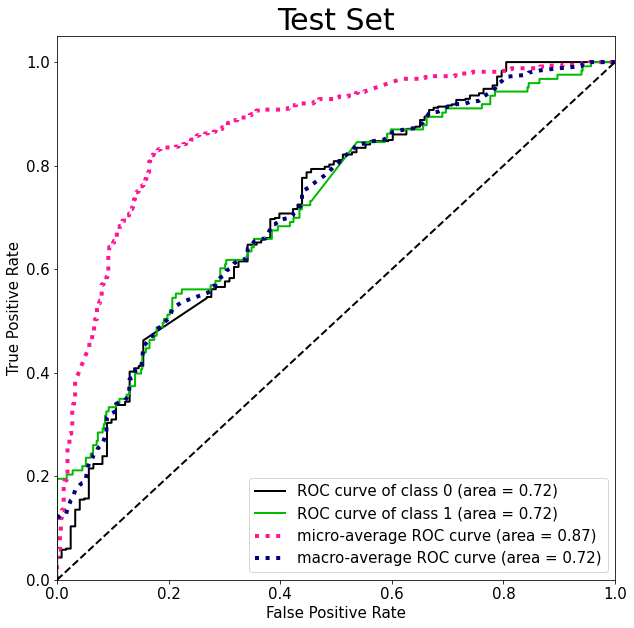

In [21]:
model.save('/data2/je_hong/kaist/kaist/physionet.org/files/mimiciv/2.0/mimic_rev/model/glyco model/glyco_best_model.h5')
model = load_model('/data2/je_hong/kaist/kaist/physionet.org/files/mimiciv/2.0/mimic_rev/model/glyco model/glyco_best_model.h5')
predictions = model.predict(x_glyco_test)
y_true = np.argmax(y_glyco_test, axis=1)
y_pred = np.argmax(predictions, axis=1)
print(predictions.shape, y_glyco_test.shape)
fpr = dict()
tpr = dict()
roc_auc = dict()
target_names = ['normal', 'diabetes']

print(classification_report(y_true, y_pred, target_names=target_names, digits=4))
print(1 - roc_auc_score(y_true, predictions[:, 0]))
print(roc_auc_score(y_true, predictions[:, 1]))
skplt.metrics.plot_roc(
    y_true, predictions, title="Test Set", figsize=(10, 10), text_fontsize=15, title_fontsize=30,
)
print(y_true.shape)

## fluoro

In [22]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=1, factor=0.6),
             EarlyStopping(monitor='val_loss', patience=20),
             ModelCheckpoint(filepath=new_path+'model/{} model'.format("fluoro"), monitor='val_loss', save_best_only=True)]

In [23]:
history = model.fit(x_fluoro_train, y_fluoro_train, 
          epochs = 40, 
          batch_size = 16, 
          validation_data=(x_fluoro_valid, y_fluoro_valid), 
          verbose=1,callbacks=callbacks)

Epoch 1/40
206/206 [==============================] - 4s 13ms/step - loss: 0.3804 - auc: 0.9066 - val_loss: 0.3687 - val_auc: 0.9052
INFO:tensorflow:Assets written to: /data2/je_hong/kaist/kaist/physionet.org/files/mimiciv/2.0/mimic_rev/model/fluoro model/assets
Epoch 2/40
206/206 [==============================] - 2s 11ms/step - loss: 0.3804 - auc: 0.9066 - val_loss: 0.3687 - val_auc: 0.9052
INFO:tensorflow:Assets written to: /data2/je_hong/kaist/kaist/physionet.org/files/mimiciv/2.0/mimic_rev/model/fluoro model/assets
Epoch 3/40
206/206 [==============================] - 2s 11ms/step - loss: 0.3804 - auc: 0.9066 - val_loss: 0.3686 - val_auc: 0.9052
INFO:tensorflow:Assets written to: /data2/je_hong/kaist/kaist/physionet.org/files/mimiciv/2.0/mimic_rev/model/fluoro model/assets
Epoch 4/40
206/206 [==============================] - 2s 10ms/step - loss: 0.3803 - auc: 0.9066 - val_loss: 0.3686 - val_auc: 0.9053
INFO:tensorflow:Assets written to: /data2/je_hong/kaist/kaist/physionet.org/fi

(182, 2) (182, 2)
              precision    recall  f1-score   support

      normal     0.8596    0.9871    0.9189       155
    diabetes     0.5000    0.0741    0.1290        27

    accuracy                         0.8516       182
   macro avg     0.6798    0.5306    0.5240       182
weighted avg     0.8062    0.8516    0.8017       182

0.6117084826762247
0.6117084826762246
(182,)


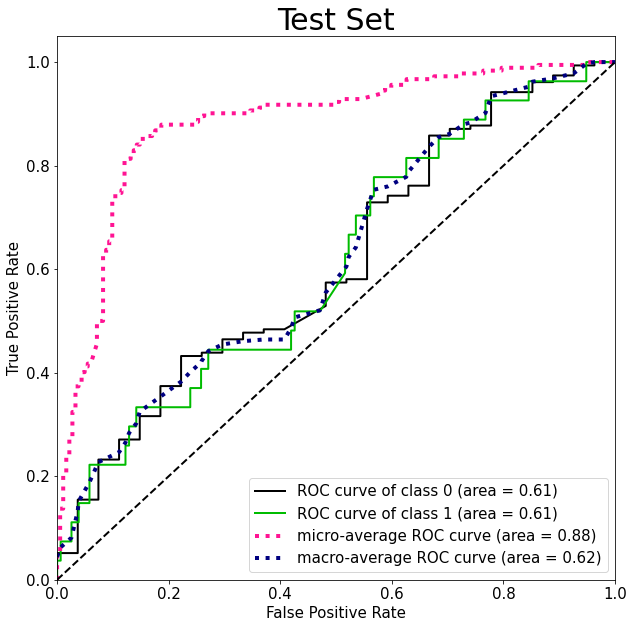

In [24]:
model.save('/data2/je_hong/kaist/kaist/physionet.org/files/mimiciv/2.0/mimic_rev/model/fluoro model/fluoro_best_model.h5')
model = load_model('/data2/je_hong/kaist/kaist/physionet.org/files/mimiciv/2.0/mimic_rev/model/fluoro model/fluoro_best_model.h5')
predictions = model.predict(x_fluoro_test)
y_true = np.argmax(y_fluoro_test, axis=1)
y_pred = np.argmax(predictions, axis=1)
print(predictions.shape, y_fluoro_test.shape)
fpr = dict()
tpr = dict()
roc_auc = dict()
target_names = ['normal', 'diabetes']

print(classification_report(y_true, y_pred, target_names=target_names, digits=4))
print(1 - roc_auc_score(y_true, predictions[:, 0]))
print(roc_auc_score(y_true, predictions[:, 1]))
skplt.metrics.plot_roc(
    y_true, predictions, title="Test Set", figsize=(10, 10), text_fontsize=15, title_fontsize=30,
)
print(y_true.shape)